<a href="https://colab.research.google.com/github/TruongGiangVu/VGG16_RNN_LSTM_SignLanguageRecognition/blob/main/CM_VGG16_RNN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip uninstall tensorflow
!pip install --no-cache-dir tensorflow==2.2.0

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0
y
     |████████████████████████████████| 516.2MB 1.4MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# common library 
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
import glob
from google.colab.patches import cv2_imshow

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
# change path
import os
os.chdir('/content/drive/MyDrive/VSLProject')
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1FHuZ4ytzi1pRYSLpL7aaEmpdDa1jCION/VSLProject


# Global params

In [ ]:
# some global params
SIZE = (64, 64) 

# SIZE = (224, 224) 
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130
classes_file = 'classes.npy'

#Funtion

## Preprocessing

In [ ]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized
  
def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

## Video to frame

In [ ]:
class MyVideo:
  def __init__(self, path='', root_path=''):
    self.path = path
    self.root = root_path
    self.video = cv2.VideoCapture(path)
    self.name = path.split("/")[-1]
    self.label = path.split("/")[-2]
  def getVideo(self):
    return self.video
  def getFullPath(self):
    return self.root + '/' + self.path
  def getFileName(self):
    return self.name
  def getFrameCount(self):
    return int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
  def getLabel(self):
    return self.label
  def release(self):
    self.video.release()
    del self


def videotoframe(myVideo, dsize=(128,128) , numframe=5, start=0, stop=0):
  listframe = []
  length = myVideo.getFrameCount()

  currentFrame = -1
  skipframe = int((length - start - stop)/numframe)
  takeframe = skipframe + start
  taken = 0
  # print('video',video,'length', length, 'skip', skipframe)
  video = myVideo.getVideo()
  while(True):
      # Capture frame-by-frame
      ret, frame = video.read()
      currentFrame += 1

      if ret == False:
          break
      if currentFrame < takeframe:
          continue
      if taken >= numframe:
          break
      frame = resizeScale(frame)
      frame = removeTrimBackground(frame, LENGTH_TRIM)
      frame = resizeImage(frame, dsize)
      listframe.append(frame)

      takeframe += skipframe
      taken += 1
  # When everything done, release the capture
  myVideo.release()
  cv2.destroyAllWindows()
  return listframe

def preprocessingVideo(myVideo):
  frames = videotoframe(myVideo, SIZE, NBFRAME, 10, 30)
  frames = np.array(frames)
  frames = frames / 255.
  return frames

def predictOneVideo(video, classes):
  # preprocessing video path
  if type(video) is not MyVideo:
    video = MyVideo(video)
  item = preprocessingVideo(video)
  item = item[None,:]  # [640,10,64,64,3]
  try:
    # a = model.predict_classes(item) # old version
    predicted = np.argmax(model.predict(item), axis=-1) # [10] [15,12]
    return classes[predicted[0]]  # [16] accept
  except: 
    print('Video', myVideo.name,'has error')
    return 'Null'
  # print(predicted)

def preparePath(path, csv_file = ''):
  paths = []
  if csv_file == '':
    videos = os.listdir(path)
    for video in videos:
        video_path = os.path.join(path, video)
        paths.append(video_path)
  else:
    with open(csv_file) as csvfile: # read path from csv
      reader = csv.reader(csvfile)
      for row in reader:
        video_path = os.path.join(path, row[0])
        paths.append(video_path)

  print(len(paths))
  return paths

## Predict video

In [ ]:
def predictVideoOneTime(paths, classes, verbose = 0):
  data = []
  names = []
  expecteds = []
  n = len(videos)
  for path in paths:
    myVideo = MyVideo(path)
    item = preprocessingVideo(myVideo)
    data.append(item)
    names.append(myVideo.getFileName())
    expecteds.append(myVideo.getLabel())

  data = np.array(data)
  # print(data.shape)
  predicted = np.argmax(model.predict(data), axis=-1)
  # print(predicted)
  # print(classes[predicted])
  dic = {}
  count = 0
  for i in range(n):
    expected = expecteds[i]
    text = 'Video: '+ names[i] + ' Expected: '+ expected + ' Predicted: '+ classes[predicted[i]]
    if expected not in dic:
      dic[expected] = 0
    if expected == classes[predicted[i]]:
      count = count + 1
      dic[expected] = dic[expected] + 1
    else:
      text = '\x1b[31m'+ text + '\x1b[0m'
    
    if verbose == 1 : 
      print(text)
  print()
  print('Accuray:',str(count)+'/'+str(n), ',',str(count/n))
  return dic

def predictVideoOneByOne(paths, classes, verbose = 0):
  dic = {}

  count = 0
  n = len(paths)
  index = 1
  for video in paths:
    myVideo = MyVideo(video)
    predicted = predictOneVideo( myVideo, classes)
    expected = myVideo.getLabel()
    print(index, end=' ')
    text = 'Video: '+ myVideo.getFileName() + ' Expected: '+  expected + ' Predicted: '+ predicted
    if expected not in dic:
      dic[expected] = 0
    if expected == predicted:
      count = count + 1
      dic[expected] = dic[expected] + 1
    else:
      text = '\x1b[31m'+ text + '\x1b[0m'
    index = index + 1
    
    if verbose == 1 : 
      print(text)
    
  print()
  print('Accuray:',str(count)+'/'+str(n), ',',str(count/n))
  return dic

def predictVideoOneByOneReturn2dDict(paths, classes, verbose = 0):
  dic = {}    # to make a confusion maxtrix, im use a 2D dictionary
  count = 0
  n = len(paths)
  index = 0
  for video in paths:
    myVideo = MyVideo(video)
    predicted = predictOneVideo( myVideo, classes)
    expected = myVideo.getLabel()
    print(index+1, end=' ')
    text = 'Video: '+ myVideo.getFileName() + ' Expected: '+  expected + ' Predicted: '+ predicted
    if expected not in dic:
      dic[expected] = dict()
    if predicted not in dic[expected]:
      dic[expected][predicted] = 0
    if expected == predicted:
      count = count + 1
      # dic[expected] = dic[expected] + 1
    else:
      text = '\x1b[31m'+ text + '\x1b[0m'
    
    # process onfusion matrix array
    dic[expected][predicted] += 1


    index = index + 1
    if verbose == 1 : 
      print(text)
    
  print()
  print('Accuray:',str(count)+'/'+str(n), ',',str(count/n))
  return dic

def predictVideo(path, csv_file, classes, verbose = 0 ,isOneTime = False):
  paths = preparePath(path, csv_file)
  
  if isOneTime == True:
    dic = predictVideoOneTime(paths, classes, verbose)
  else:
    dic = predictVideoOneByOneReturn2dDict(paths, classes, verbose)
  return dic

# Model

In [ ]:
def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_VGG16_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))

  model.add(SimpleRNN(256, dropout=0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Main

In [ ]:
# read classes from file
classes_file = 'classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE) 
model = LSTMModel(INSHAPE, num_classes)
model.load_weights('chkp/weights-RNN-10_05.hdf5')
# model.load_weights('chkp/weights-LSTM-095625-08_05.hdf5')

print(num_classes,classes)

['Accept' 'Appear' 'Argentina' 'Away' 'Barbecue' 'Bathe' 'Birthday'
 'Bitter' 'Born' 'Breakfast' 'Bright' 'Buy' 'Call' 'Candy' 'Catch'
 'Chewing-gum' 'Coin' 'Colors' 'Copy' 'Country' 'Dance' 'Deaf' 'Drawer'
 'Enemy' 'Find' 'Food' 'Give' 'Green' 'Help' 'Hungry' 'Last name' 'Learn'
 'Light-blue' 'Man' 'Map' 'Milk' 'Mock' 'Music' 'Name' 'None' 'Opaque'
 'Patience' 'Perfume' 'Photo' 'Realize' 'Red' 'Red_2' 'Rice' 'Run' 'Ship'
 'Shut down' 'Skimmer' 'Son' 'Spaghetti' 'Sweet milk' 'Thanks' 'To land'
 'Trap' 'Uruguay' 'Water' 'Where' 'Women' 'Yellow' 'Yogurt']
Model loaded..!
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 

In [ ]:
start = time.time()

res = predictVideo(
    path='Datasets/lsa64_split/test', 
    csv_file='Datasets/lsa64_videoperfolder/test.csv', 
    classes=classes,
    verbose=1,
    isOneTime = False)

end = time.time()
print('time:', end - start)

640
1 Video: 049_001_005.mp4 Expected: Yogurt Predicted: Yogurt
2 Video: 049_002_005.mp4 Expected: Yogurt Predicted: Yogurt
3 Video: 049_003_005.mp4 Expected: Yogurt Predicted: Yogurt
4 Video: 049_004_005.mp4 Expected: Yogurt Predicted: Yogurt
5 Video: 049_005_005.mp4 Expected: Yogurt Predicted: Yogurt
6 Video: 049_006_005.mp4 Expected: Yogurt Predicted: Yogurt
7 Video: 049_007_005.mp4 Expected: Yogurt Predicted: Yogurt
8 Video: 049_008_005.mp4 Expected: Yogurt Predicted: Yogurt
9 Video: 049_009_005.mp4 Expected: Yogurt Predicted: Yogurt
10 Video: 049_010_005.mp4 Expected: Yogurt Predicted: Yogurt
11 Video: 009_001_005.mp4 Expected: Women Predicted: Yellow
12 Video: 009_002_005.mp4 Expected: Women Predicted: Opaque
13 Video: 009_003_005.mp4 Expected: Women Predicted: Son
14 Video: 009_004_005.mp4 Expected: Women Predicted: Women
15 Video: 009_005_005.mp4 Expected: Women Predicted: Women
16 Video: 009_006_005.mp4 Expected: Women Predicted: Son
17 Video: 009_007_005.mp4 Expected: Women P

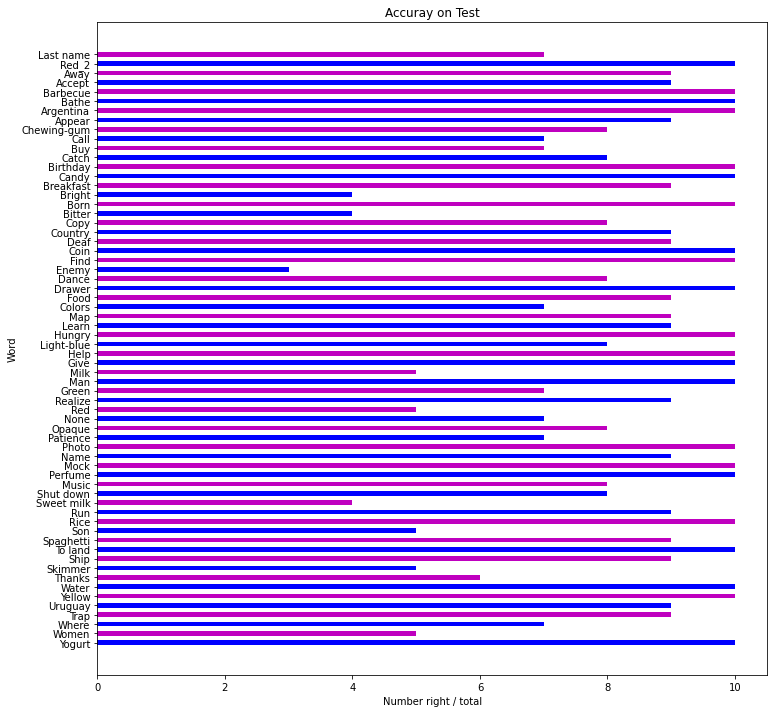

In [ ]:
sorted(res)
ticks=range(len(res))
height=list(res.values())
tick_label=list(res.keys())

fig = plt.figure(figsize=(12, 12))
plt.barh(ticks,height,tick_label=tick_label,color=['b','m'],height=0.5, align='center')
plt.title("Accuray on Test")
plt.ylabel("Word")
plt.xlabel("Number right / total")
plt.show()

In [ ]:
a = np.array(list(res.values()))
print(a)

[10 10 10 10 10 10  9 10 10 10 10 10  9 10 10 10  9 10 10 10 10 10 10  9
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10
  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [ ]:
# exchange result dict to confusion array
a = np.zeros((64,64), dtype=int)
a_true = list(res.keys())
a_pred = list(res.keys())
print(a_true)

matrix = list(res.values())
for w_class in a_true:
  for word in list(res[w_class]):
    a[a_true.index(w_class)][a_true.index(word)] = res[w_class][word]

print(a)

['Yogurt', 'Women', 'Where', 'Trap', 'Uruguay', 'Yellow', 'Water', 'Thanks', 'Skimmer', 'Ship', 'To land', 'Spaghetti', 'Son', 'Rice', 'Run', 'Sweet milk', 'Shut down', 'Music', 'Perfume', 'Mock', 'Name', 'Photo', 'Patience', 'Opaque', 'None', 'Red', 'Realize', 'Green', 'Man', 'Milk', 'Give', 'Help', 'Light-blue', 'Hungry', 'Learn', 'Map', 'Colors', 'Food', 'Drawer', 'Dance', 'Enemy', 'Find', 'Coin', 'Deaf', 'Country', 'Copy', 'Bitter', 'Born', 'Bright', 'Breakfast', 'Candy', 'Birthday', 'Catch', 'Buy', 'Call', 'Chewing-gum', 'Appear', 'Argentina', 'Bathe', 'Barbecue', 'Accept', 'Away', 'Red_2', 'Last name']
[[10  0  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  7]]


In [ ]:
# remove class with 90% predicted from confusion array
i=0
while i < (np.shape(a)[0]):
    c_true = 0
    true_max = 0
    for j in range(np.shape(a)[1]):
        if a[i][j] > 0:
            c_true += 1
            if true_max < a[i][j]:
              true_max = a[i][j]
    if c_true <= 2 and true_max >= 9:
        a = np.delete(a,i,0)
        a_true = np.delete(a_true,i,0)
        i-=1
    i+=1

i=0
while i < (np.shape(a)[1]):
    c_pred = 0
    for j in range(np.shape(a)[0]):
      if a[j][i] > 0:
          c_pred += 1
    if c_pred == 0:
        a = np.delete(a,i,1)
        a_pred = np.delete(a_pred,i,0)
        i-=1
    i+=1

print('a_true: ',a_true)
print('a_pred: ',a_pred)
print(a)

a_true:  ['Women' 'Where' 'Thanks' 'Skimmer' 'Son' 'Sweet milk' 'Shut down' 'Music'
 'Patience' 'Opaque' 'None' 'Red' 'Green' 'Milk' 'Light-blue' 'Colors'
 'Dance' 'Enemy' 'Copy' 'Bitter' 'Bright' 'Catch' 'Buy' 'Call'
 'Chewing-gum' 'Last name']
a_pred:  ['Women' 'Where' 'Trap' 'Yellow' 'Water' 'Thanks' 'Skimmer' 'Ship' 'Son'
 'Rice' 'Sweet milk' 'Shut down' 'Music' 'Perfume' 'Name' 'Photo'
 'Patience' 'Opaque' 'None' 'Red' 'Green' 'Man' 'Milk' 'Give' 'Light-blue'
 'Hungry' 'Colors' 'Food' 'Drawer' 'Dance' 'Enemy' 'Find' 'Coin' 'Deaf'
 'Country' 'Copy' 'Bitter' 'Bright' 'Breakfast' 'Candy' 'Catch' 'Buy'
 'Call' 'Chewing-gum' 'Away' 'Red_2' 'Last name']
[[5 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 7]]


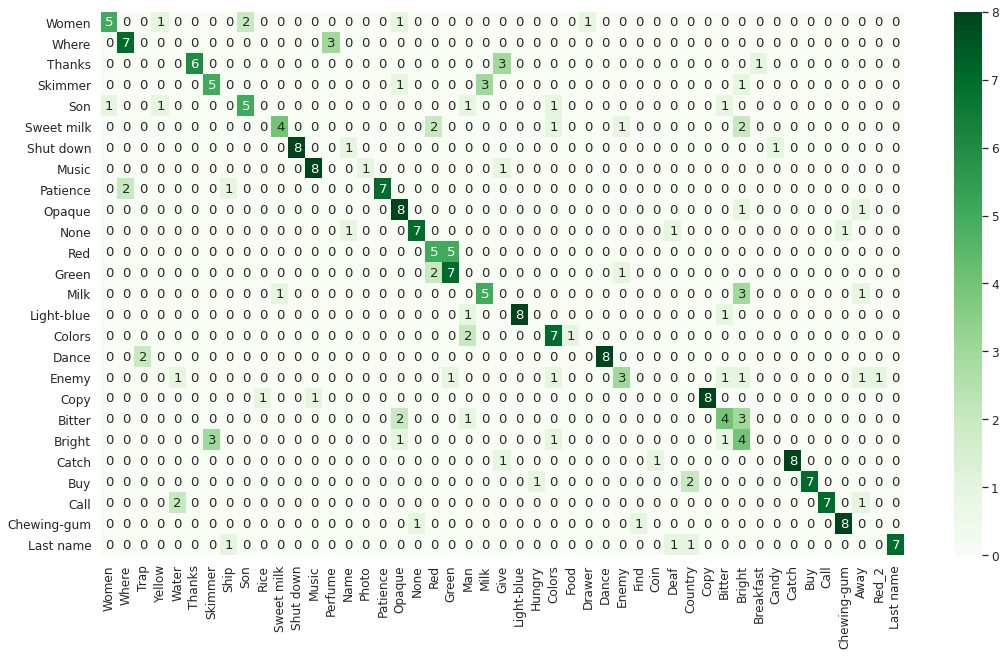

In [ ]:
# draw the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(a, index = [i for i in a_true], columns = [i for i in a_pred])
plt.figure(figsize=(18,10))
sn.set(font_scale=1.1) # for label size
sn.heatmap(df_cm, annot=True, cmap = 'Greens') # font size

plt.show()

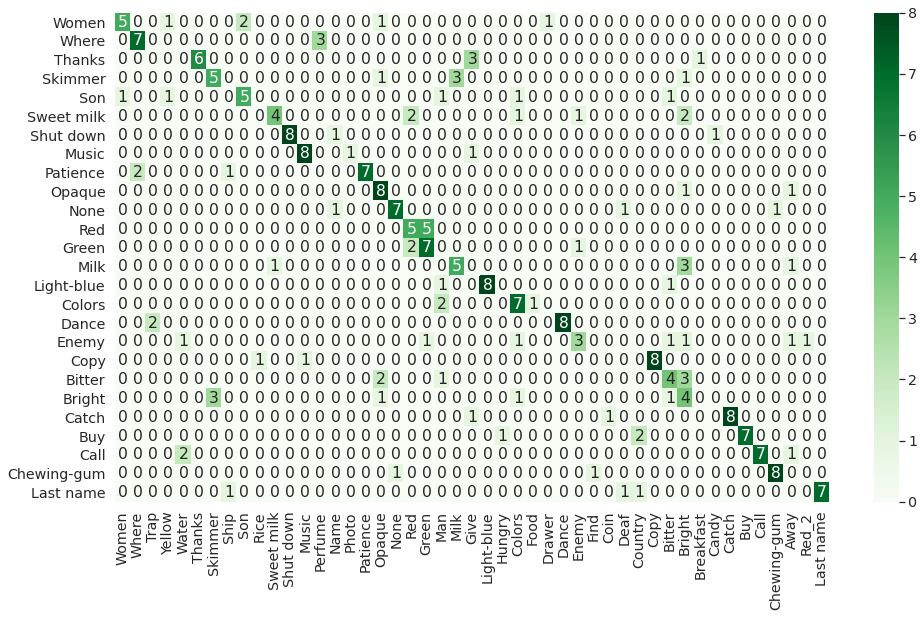

In [ ]:
# draw the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(a, index = [i for i in a_true], columns = [i for i in a_pred])
plt.figure(figsize=(16,9))
sn.set(font_scale=1.3) # for label size
sn.heatmap(df_cm, annot=True, cmap = 'Greens') # font size

plt.show()